In [120]:
import warnings
from functools import wraps


def ignore_warnings(f):
    @wraps(f)
    def inner(*args, **kwargs):
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("ignore")
            response = f(*args, **kwargs)
        return response
    return inner

In [121]:
import sklearn
import math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import stream as st

In [122]:
print(st.__version__)
values = (np.load("../BIO_Ml/GSE52588/GSE52588_beta_fn.npz"))["X"]
data = pd.read_csv("../BIO_Ml/GSE52588/GSE52588_samples.csv", delim_whitespace=True)

1.1


In [123]:
gene_names = pd.read_csv("../BIO_Ml/GSE52588/cpgs_annotations.csv")
cpg_names = pd.read_csv("../BIO_Ml/GSE52588/cpgs_annotations.csv")
cpg_names = cpg_names["ID_REF"]
cpg_names = cpg_names.replace(np.nan, "0")
x_cpg = pd.DataFrame(data=values, columns=cpg_names[:422802])
x_cpg["Age"] = data["age"]
x_cpg["Gene_Name"] = gene_names["UCSC_REFGENE_NAME"]

In [124]:
y = x_cpg["Age"]
#y = y.to_numpy()
X = x_cpg.drop(["Age", "Gene_Name"], axis=1)
#X = Normalizer().fit_transform(X)

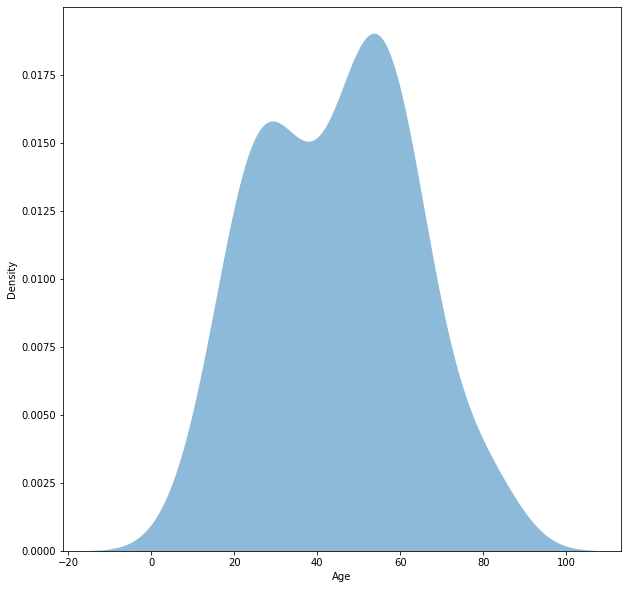

In [125]:
y = y[29:]
X = X[29:]

sns.kdeplot(data=y,
            fill=True,
            alpha=0.5,
            palette="crest",
            linewidth=0)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [126]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector_k = SelectKBest(score_func=f_regression, k=50)
fit = selector_k.fit(X, y)
cols = selector_k.get_support(indices=True)
X = X.iloc[:, cols]
#X = fit.transform(X)

#X.to_csv('out.zip', index=False, compression="zip")

In [127]:
column_lables = pd.DataFrame(data=X.columns)
column_lables.to_csv("column_lables.csv", index=False, header=False)

In [128]:
# adata = st.read(file_name='out.csv',delimiter=',')
# st.add_cell_labels(adata,file_name='column_lables.csv')
#
# st.plot_visualization_2D(adata, method="umap", n_neighbors=10)
# st.seed_elastic_principal_graph(adata, n_clusters=10,use_vis=True)
# st.plot_dimension_reduction(adata,n_components=2,show_graph=True,show_text=False)
# st.plot_branches(adata,show_text=True)

In [129]:
feature = 12
ox = y
oy = X.iloc[:, feature]

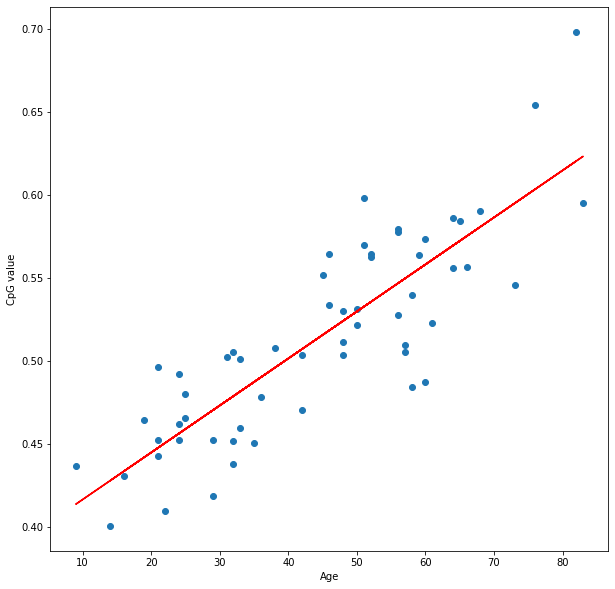

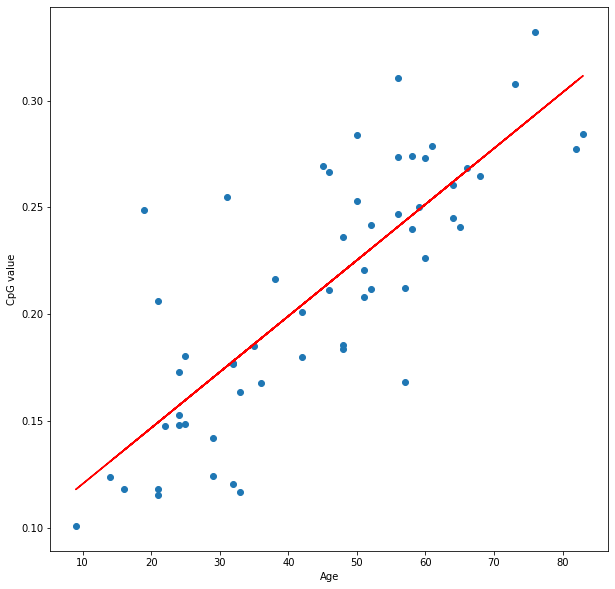

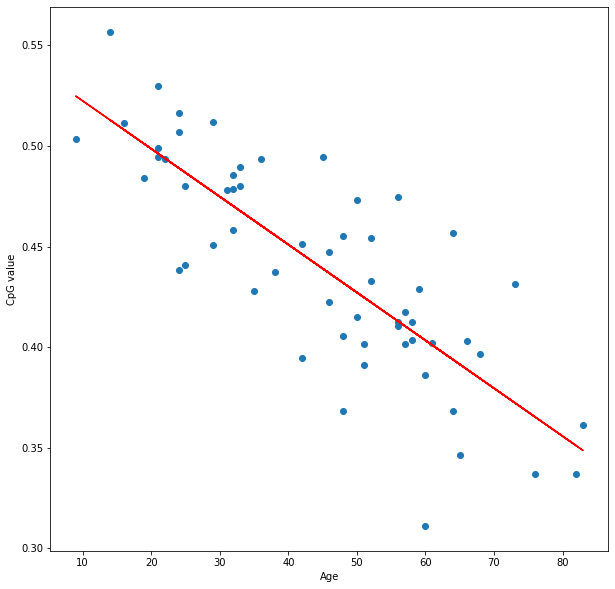

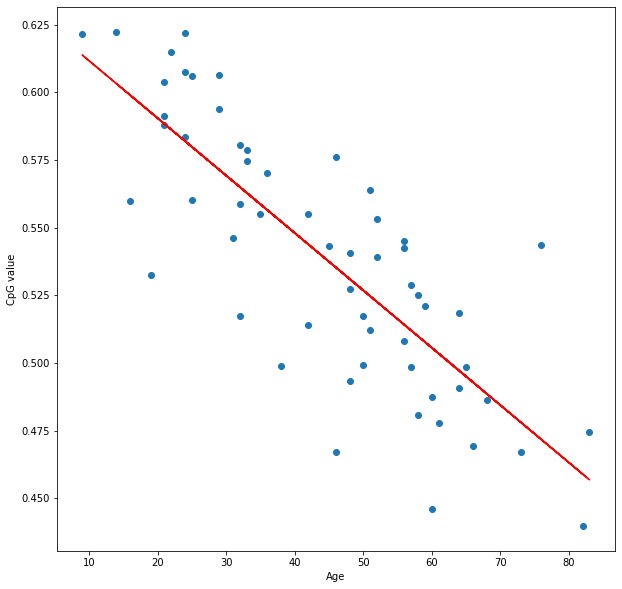

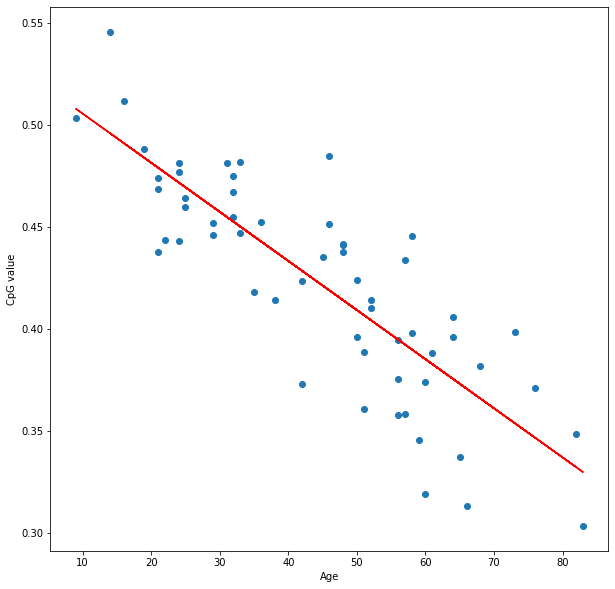

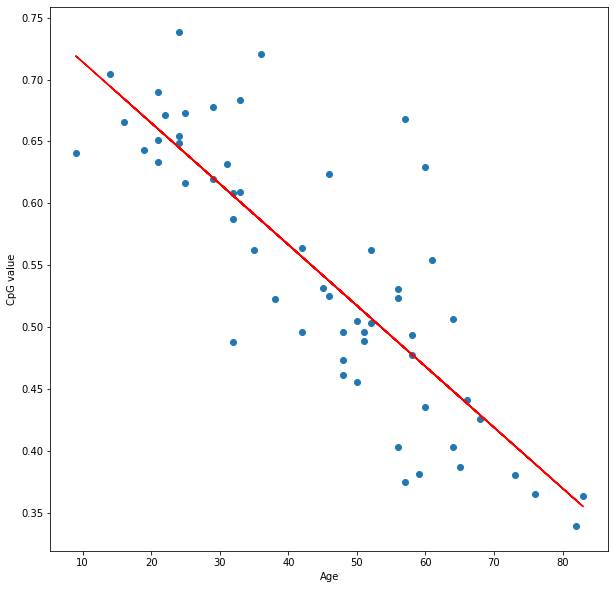

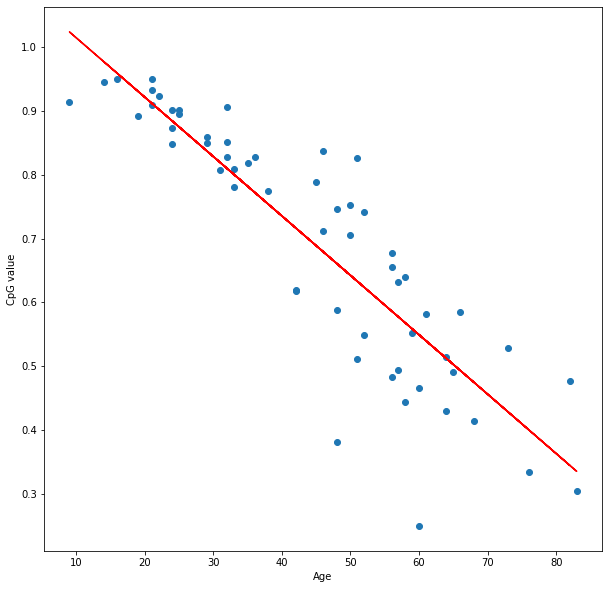

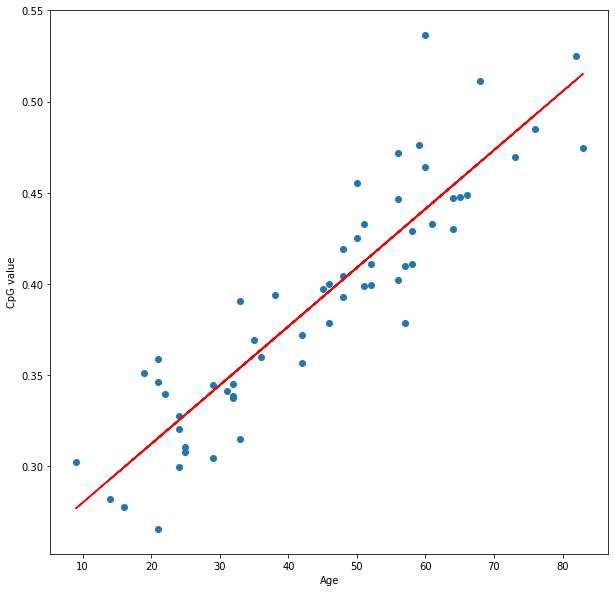

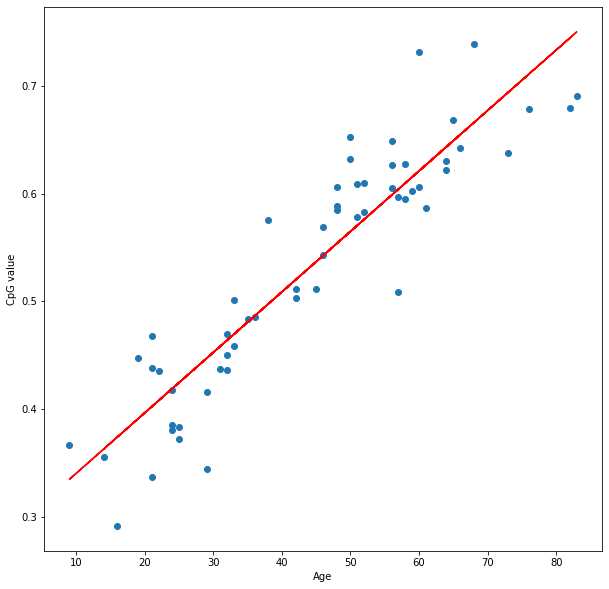

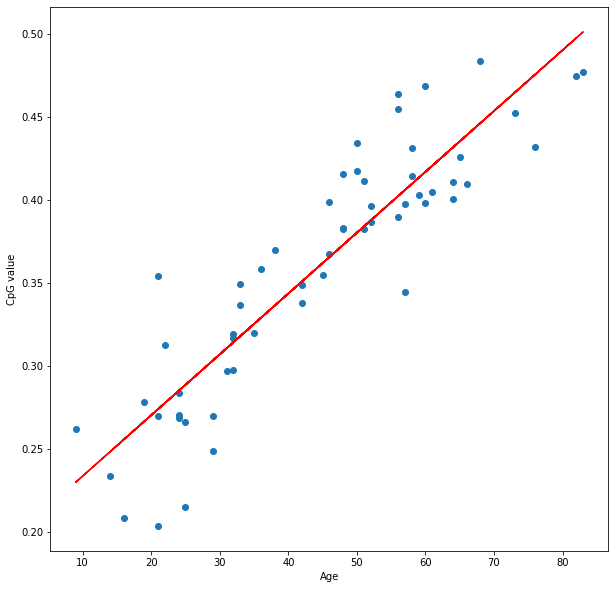

In [130]:
for i in range(10):
    oy = X.iloc[:, i]
    fig = plt.figure()
    ax = plt.axes()
    m, b = np.polyfit(ox, oy, 1)
    ax.plot(ox, m * ox + b, c="r")
    ax.scatter(ox, oy)
    plt.xlabel("Age")
    plt.ylabel("CpG value")
    fig.show

In [131]:
t_df = X
t_df["Age"] = y
corr = t_df.corr()
corr.style.background_gradient(cmap='coolwarm',
                               vmin=-1,
                               vmax=1)

ID_REF,cg00545916,cg00834400,cg01098651,cg01148728,cg01474720,cg01704862,cg01718738,cg02711724,cg02711726,cg02711801,cg02898915,cg03645571,cg03694279,cg04935449,cg04972384,cg05443789,cg05560165,cg06005177,cg06165706,cg06931676,cg06931695,cg06931815,cg06980204,cg07015886,cg07997333,cg09574499,cg09575189,cg09575242,cg09575258,cg10319331,cg10389584,cg10533694,cg10635065,cg13133084,cg14178173,cg14321275,cg15883721,cg16567087,cg16899823,cg17296483,cg18566911,cg19483048,cg19924719,cg20090859,cg20273260,cg20607769,cg20639948,cg21226353,cg21510189,cg22558685,Age
ID_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cg00545916,1.000000,0.760361,-0.684750,-0.648773,-0.708649,-0.718368,-0.716971,0.797843,0.799697,0.790753,-0.667658,-0.677415,-0.712345,0.764707,-0.670084,0.819337,-0.675052,-0.580987,0.701351,0.851388,0.836918,0.795359,0.795334,0.821702,0.794288,0.710192,0.849359,0.783710,0.708902,-0.668866,0.757314,0.735206,-0.723035,0.747314,-0.744678,0.752816,0.729112,0.822386,0.821767,0.703797,-0.630442,-0.695876,0.729128,-0.684526,-0.720464,-0.645302,-0.696323,0.728337,0.795592,0.838109,0.844114
cg00834400,0.760361,1.000000,-0.640822,-0.670843,-0.647847,-0.727452,-0.714331,0.795659,0.805006,0.801901,-0.629260,-0.712574,-0.678355,0.818592,-0.721489,0.812788,-0.744423,-0.583389,0.738394,0.819860,0.826378,0.840233,0.812724,0.736574,0.855962,0.758705,0.748202,0.765054,0.708106,-0.675706,0.833690,0.849800,-0.658223,0.770195,-0.629905,0.772725,0.749593,0.817057,0.813293,0.801161,-0.697043,-0.688242,0.773147,-0.748253,-0.664082,-0.710592,-0.718046,0.840533,0.830576,0.833062,0.803788
cg01098651,-0.684750,-0.640822,1.000000,0.714501,0.720804,0.762163,0.839918,-0.739360,-0.771699,-0.719839,0.763646,0.783056,0.879838,-0.665666,0.800363,-0.597585,0.702208,0.749666,-0.559514,-0.764110,-0.607249,-0.695479,-0.711231,-0.618522,-0.616884,-0.627193,-0.696109,-0.655957,-0.558592,0.710408,-0.590829,-0.615521,0.730397,-0.654451,0.767672,-0.510798,-0.628685,-0.586529,-0.692416,-0.540195,0.838171,0.784314,-0.665382,0.813626,0.799471,0.733700,0.720959,-0.620262,-0.603944,-0.643695,-0.806965
cg01148728,-0.648773,-0.670843,0.714501,1.000000,0.646391,0.723741,0.719447,-0.781041,-0.772963,-0.743187,0.657694,0.659517,0.770614,-0.724469,0.680068,-0.627923,0.701773,0.663880,-0.766911,-0.702191,-0.578467,-0.690634,-0.630317,-0.567486,-0.680493,-0.696288,-0.758929,-0.742968,-0.723562,0.728445,-0.682221,-0.695351,0.659694,-0.732435,0.585765,-0.647453,-0.693485,-0.594447,-0.774626,-0.584700,0.764980,0.781211,-0.648902,0.795317,0.683728,0.786894,0.772708,-0.746826,-0.686991,-0.634936,-0.804030
cg01474720,-0.708649,-0.647847,0.720804,0.646391,1.000000,0.710239,0.754051,-0.773041,-0.757003,-0.719342,0.661541,0.748166,0.761416,-0.667693,0.806417,-0.679226,0.767026,0.684709,-0.637629,-0.800238,-0.652833,-0.731636,-0.723421,-0.628220,-0.651085,-0.712026,-0.750088,-0.701013,-0.636215,0.738484,-0.663019,-0.663035,0.711863,-0.614840,0.829269,-0.621837,-0.744714,-0.661498,-0.730593,-0.607092,0.712788,0.791832,-0.614339,0.741434,0.725698,0.747170,0.674119,-0.642806,-0.685541,-0.702564,-0.830684
cg01704862,-0.718368,-0.727452,0.762163,0.723741,0.710239,1.000000,0.792663,-0.767550,-0.777379,-0.759283,0.709019,0.686246,0.774467,-0.745756,0.750987,-0.692382,0.723859,0.724212,-0.628036,-0.780023,-0.735587,-0.746963,-0.742491,-0.711717,-0.711269,-0.621468,-0.759259,-0.734259,-0.698180,0.709806,-0.710095,-0.648198,0.822228,-0.790536,0.713208,-0.661268,-0.666231,-0.702432,-0.740277,-0.679825,0.732403,0.742845,-0.801398,0.735236,0.771733,0.756262,0.722509,-0.732253,-0.696305,-0.735423,-0.829937
cg01718738,-0.716971,-0.714331,0.839918,0.719447,0.754051,0.792663,1.000000,-0.832898,-0.842254,-0.820994,0.803893,0.780228,0.843960,-0.727038,0.816770,-0.682271,0.866923,0.767217,-0.633363,-0.859878,-0.726643,-0.804637,-0.764331,-0.718604,-0.708883,-0.708083,-0.754489,-0.748113,-0.677517,0.757899,-0.707551,-0.731139,0.785151,-0.738846,0.726466,-0.616407,-0.693597,-0.695506,-0.765613,-0.684222,

C:\Users\Eugen\AppData\Local\Temp/ipykernel_16876/92398548.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


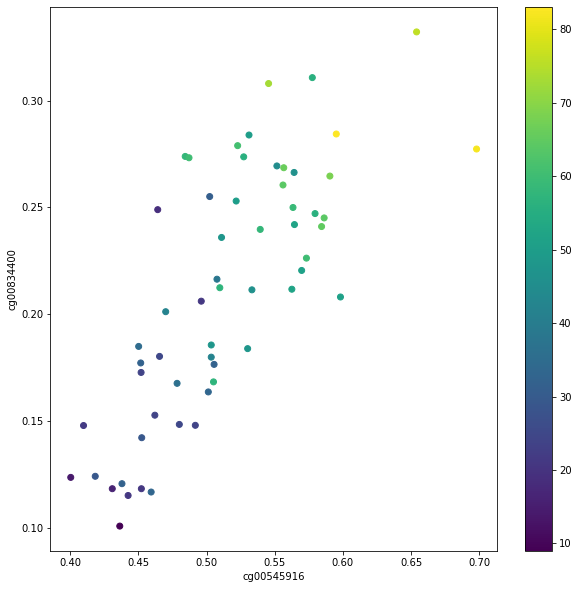

In [132]:
fig3 = plt.figure()
ax = plt.axes()
cpg1 = X.iloc[:, 0]
cpg2 = X.iloc[:, 1]

image = ax.scatter(cpg1, cpg2, c=y)
fig3.colorbar(image, ax=ax)
df_columns = X.columns

plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel(df_columns[0])
plt.ylabel(df_columns[1])

fig3.show()

In [133]:
gene_names = pd.read_csv("../BIO_Ml/GSE52588/cpgs_annotations.csv")
gene_names = gene_names[["ID_REF", "UCSC_REFGENE_NAME"]]
gene_names = gene_names.replace(np.nan, "0")

important_cpgs = list(X.columns)
gene_names = gene_names[gene_names["ID_REF"].isin(important_cpgs)]
gene_names = gene_names.drop(gene_names[gene_names["UCSC_REFGENE_NAME"] == "0"].index).drop_duplicates()
gene_names = gene_names["UCSC_REFGENE_NAME"].drop_duplicates()

for i in range(len(gene_names)):
    gene_names.iloc[i] = set(gene_names.iloc[i].split(";"))

gene_names = gene_names.reset_index()
gene_names = gene_names["UCSC_REFGENE_NAME"]
# gene_names.to_excel("gene_names_CpG_based.xlsx", index = False)

In [134]:
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev

#regressor = RandomForestRegressor(n_estimators=42, criterion="absolute_error", random_state=42)
regressor = SVR(kernel="poly", C=1.5)
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
lst_accu_stratified = []

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    regressor.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(regressor.score(x_test_fold, y_test_fold))

print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified) * 100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified) * 100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified) * 100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

c:\users\eugen\pycharmprojects\python_study\venv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


List of possible accuracy: [0.7517918707841859, 0.7707321024946729]

Maximum Accuracy That can be obtained from this model is: 77.0732102494673 %

Minimum Accuracy: 75.17918707841858 %

Overall Accuracy: 76.12619866394294 %

Standard Deviation is: 0.013392766279729901


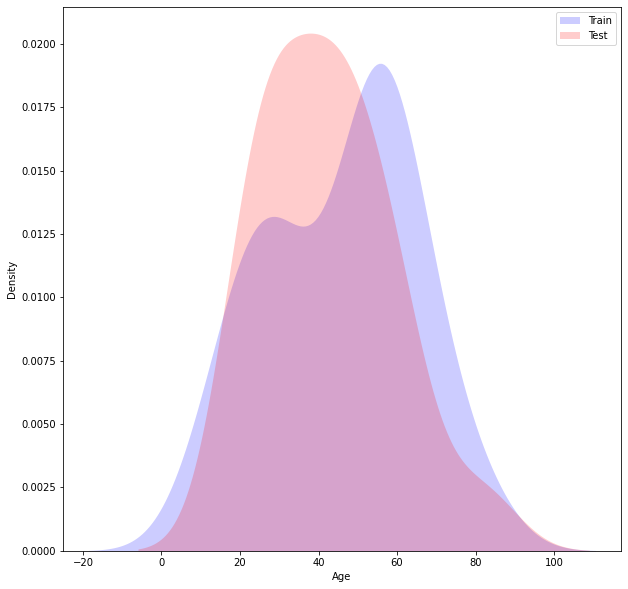

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
sns.kdeplot(y_train, color='b', fill=True, alpha=.2, linewidth=0)
sns.kdeplot(y_test, color="r", fill=True, alpha=.2, linewidth=0)
plt.rcParams["figure.figsize"] = (10,10)
plt.legend(["Train", "Test"])
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

In [136]:
regressor = SVR(kernel="poly", C=1.5)
model = regressor.fit(X_train, y_train)

In [137]:
y_pred = regressor.predict(X_test)
res = pd.DataFrame({"Actual": y_test, "Predicted": y_pred,
                    "AE": y_test - y_pred,
                    "SE": (y_test - y_pred) ** 2})
print("MAE: ", mean_absolute_error(y_test, y_pred), "MSE: ", mean_squared_error(y_test, y_pred))
print(res)


MAE:  5.0140936762719965 MSE:  42.04074294781883
    Actual  Predicted         AE          SE
29      21  32.348922 -11.348922  128.798035
34      24  32.905674  -8.905674   79.311028
63      56  52.549649   3.450351   11.904923
42      36  36.901220  -0.901220    0.812197
73      46  43.056015   2.943985    8.667047
81      61  58.771002   2.228998    4.968432
66      64  63.026188   0.973812    0.948311
54      33  35.598444  -2.598444    6.751912
75      45  42.304255   2.695745    7.267040
41      32  35.213584  -3.213584   10.327122
77      82  98.045360 -16.045360  257.453577
32      21  32.347645 -11.347645  128.769056
65      51  47.339208   3.660792   13.401398
60      42  40.229206   1.770794    3.135713
37      33  35.597232  -2.597232    6.745613
46      24  32.905663  -8.905663   79.310825
35      25  33.124484  -8.124484   66.007248
33      42  40.224427   1.775573    3.152661
70      56  52.547259   3.452741   11.921423
48      48  44.659147   3.340853   11.161298


  0%|          | 0/20 [00:00<?, ?it/s]

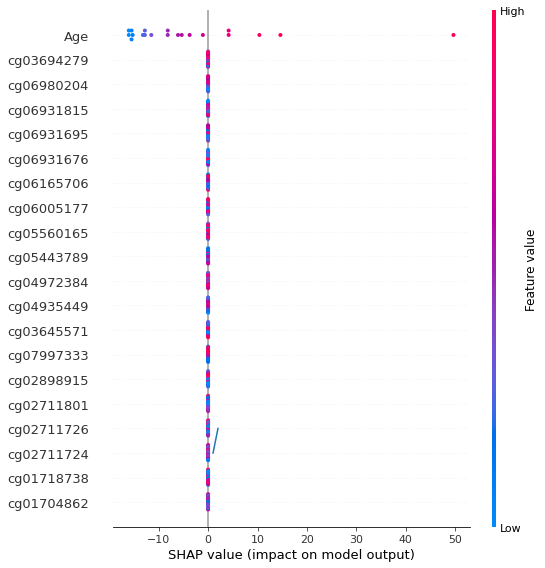

In [138]:
import shap
X_train_summary = shap.kmeans(X_train, 10)
plt.plot([1, 2], [2, 3])

@ignore_warnings
def kernel_explain(X_train_summary, regressor, X_test):
    ex = shap.KernelExplainer(regressor.predict, X_train_summary)
    shap_values = ex.shap_values(X_test)
    return shap_values, ex

shap_values, ex = kernel_explain(X_train_summary, regressor, X_test)
shap.summary_plot(shap_values, X_test)

In [139]:
y_test = y_test.to_numpy()

1.0.1


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


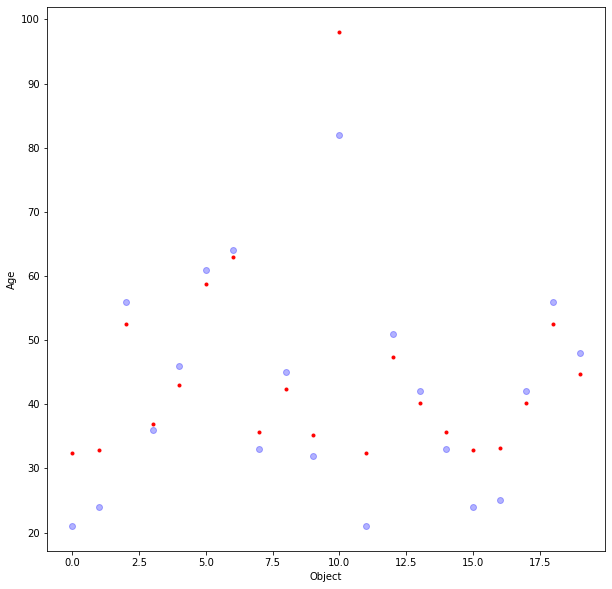

In [140]:
fig4 = plt.figure()
ax = plt.axes()

plt.plot(y_pred, ".", c="r")
plt.plot(y_test, "o", c="b", alpha=0.3)
plt.xlabel("Object")
plt.ylabel("Age")
plt.rcParams["figure.figsize"] = (10,10)

fig4.show()
print(sklearn.__version__)